# Draft of in-class transcript from Lecture 15, March 11, 2019


# Imports and defs for lecture

In [1]:
# These are the standard imports for CS 111. 
# This list may change as the quarter goes on.

import os
import math
import time
import struct
import json
import pandas as pd
import networkx as nx
import numpy as np
import numpy.linalg as npla
import scipy
import scipy.sparse.linalg as spla
from scipy import sparse
from scipy import linalg
from scipy import integrate
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d



In [2]:
# Making matrices for the discrete Laplacian operator 

# One dimension 
def make_A_1D(k):
    """Create the matrix of the discrete Laplacian operator in one dimension on a k-point grid.
    Parameters: 
      k: number of grid points.
    Outputs:
      A: the sparse k-by-k matrix representing the finite difference approximation to Laplace's equation.
    """
    # First make a list with one triple (row, column, value) for each nonzero element of A
    triples = []
    for x in range(k):

        # what row of the matrix is grid point x?
        row = x
        
        # the diagonal element in this row
        col = row
        triples.append((row, col, 2.0))
        # connect to grid neighbors in x dimension
        if x > 0:
            col = row - 1
            triples.append((row, col, -1.0))
        if x < k - 1:
            col = row + 1
            triples.append((row, col, -1.0))

    # Finally convert the list of triples to a scipy sparse matrix
    ndim = k
    rownum = [t[0] for t in triples]
    colnum = [t[1] for t in triples]
    values = [t[2] for t in triples]
    A = sparse.csr_matrix((values, (rownum, colnum)), shape = (ndim, ndim))
    
    return A 


# Two dimensions 
def make_A_2D(k):
    """Create the matrix of the discrete Laplacian operator in two dimensions on a k-by-k grid.
    Parameters: 
      k: number of grid points in each dimension.
    Outputs:
      A: the sparse k**2-by-k**2 matrix representing the finite difference approximation to Laplace's equation.
    """
    # First make a list with one triple (row, column, value) for each nonzero element of A
    triples = []
    for x in range(k):
        for y in range(k):
                
            # what row of the matrix is grid point (x,y)?
            row = x + k*y

            # the diagonal element in this row
            col = row
            triples.append((row, col, 4.0))
            # connect to grid neighbors in x dimension
            if x > 0:
                col = row - 1
                triples.append((row, col, -1.0))
            if x < k - 1:
                col = row + 1
                triples.append((row, col, -1.0))
            # connect to grid neighbors in y dimension
            if y > 0:
                col = row - k
                triples.append((row, col, -1.0))
            if y < k - 1:
                col = row + k
                triples.append((row, col, -1.0))

    # Finally convert the list of triples to a scipy sparse matrix
    ndim = k*k
    rownum = [t[0] for t in triples]
    colnum = [t[1] for t in triples]
    values = [t[2] for t in triples]
    A = sparse.csr_matrix((values, (rownum, colnum)), shape = (ndim, ndim))
    
    return A 


# Three dimensions
def make_A_3D(k):
    """Create the matrix of the discrete Laplacian operator in three dimensions on a k-by-k-by-k grid.
    Parameters: 
      k: number of grid points in each dimension.
    Outputs:
      A: the sparse k**3-by-k**3 matrix representing the finite difference approximation to Laplace's equation.
    """
    # First make a list with one triple (row, column, value) for each nonzero element of A
    triples = []
    for x in range(k):
        for y in range(k):
            for z in range(k):
                
                # what row of the matrix is grid point (x,y,z)?
                row = x + y*k + z*k*k
                
                # the diagonal element in this row
                col = row
                triples.append((row, col, 6.0))
                # connect to grid neighbors in x dimension
                if x > 0:
                    col = row - 1
                    triples.append((row, col, -1.0))
                if x < k - 1:
                    col = row + 1
                    triples.append((row, col, -1.0))
                # connect to grid neighbors in y dimension
                if y > 0:
                    col = row - k
                    triples.append((row, col, -1.0))
                if y < k - 1:
                    col = row + k
                    triples.append((row, col, -1.0))
                # connect to grid neighbors in z dimension
                if z > 0:
                    col = row - k*k
                    triples.append((row, col, -1.0))
                if z < k - 1:
                    col = row + k*k
                    triples.append((row, col, -1.0))

    # Finally convert the list of triples to a scipy sparse matrix
    ndim = k*k*k
    rownum = [t[0] for t in triples]
    colnum = [t[1] for t in triples]
    values = [t[2] for t in triples]
    A = sparse.csr_matrix((values, (rownum, colnum)), shape = (ndim, ndim))
    
    return A 

In [3]:
# Make right-hand side vector just for 2D Poisson equation 

def make_b(k, top = 0, bottom = 0, left = 0, right = 0):
    """Create the right-hand side for the temperature problem on a k-by-k grid.
    Parameters: 
      k: number of grid points in each dimension.
      top: list of k values for top boundary (optional, defaults to 0)
      bottom: list of k values for bottom boundary (optional, defaults to 0)
      left: list of k values for top boundary (optional, defaults to 0)
      right: list of k values for top boundary (optional, defaults to 0)
    Outputs:
      b: the k**2 element vector (as a numpy array) for the rhs of the Poisson equation with given boundary conditions
    """
    # Start with a vector of zeros
    ndim = k*k
    b = np.zeros(shape = ndim)
    
    # Fill in the four boundaries as appropriate
    b[0        : k       ] += top
    b[ndim - k : ndim    ] += bottom
    b[0        : ndim : k] += left
    b[k-1      : ndim : k] += right
    
    return b
    
    
def radiator(k, width = .3, temperature = 100.):
    """Create one wall with a radiator
    Parameters: 
      k: number of grid points in each dimension; length of the wall.
      width: width of the radiator as a fraction of length of the wall (defaults to 0.2)
      temperature: temperature of the radiator (defaults to 100)
    Outputs:
      wall: the k element vector (as a numpy array) for the boundary conditions at the wall
    """
    rad_start = int(k * (0.5 - width/2))
    rad_end = int(k * (0.5 + width/2))
    wall = np.zeros(k)
    wall[rad_start : rad_end] = temperature
    
    return wall


# Lecture starts here

In [4]:
k = 10
A = make_A_1D(k)
A.todense()

matrix([[ 2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  2., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  2., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  2., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  2., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  2.]])

u is: [ 3.18181818  6.36363636  9.54545455 12.72727273 15.90909091 19.09090909
 22.27272727 25.45454545 28.63636364 31.81818182]


Text(0.5,1,'1-dimensional Poisson equation (temperature)')

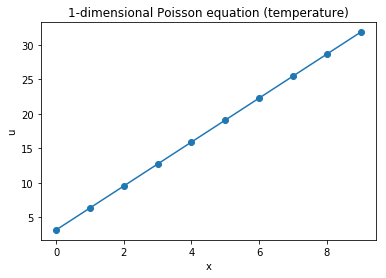

In [5]:
# Poisson equation (temperature equation) in 1D
#   d^2 u / dx^2 = 0, with boundary conditions at endpoints of unit interval.
# This is pretty simple; the answer is always a straight line.

# Choose how finely to discretize
k = 10

# Get the matrix (the finite-difference discretization of the Laplace operator)
A = make_A_1D(k)

# Get the right-hand side, with boundary conditions
b = np.zeros(k)
b[0] = 0
b[k-1] = 35

# Solve the system
u = spla.spsolve(A,b)

# Report the results
print('u is:', u)
%matplotlib inline
plt.figure()
plt.plot(range(k), u, 'o-')
plt.xlabel('x')
plt.ylabel('u')
plt.title('1-dimensional Poisson equation (temperature)')


u.shape: (10000,)


Text(0.5,1,'2-dimensional Poisson equation (temperature)')

<Figure size 432x288 with 0 Axes>

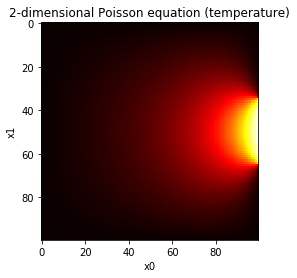

In [6]:
# Poisson equation (temperature equation) in 2D.
#   d^2 u / dx0^2 + d^2 u / dx1^2 = 0, with boundary conditions on borders of unit square.
# We've done this before.

# Choose how finely to discretize
k = 100

# Get the matrix (the finite-difference discretization of the Laplace operator)
A = make_A_2D(k)

# Get the right-hand side, with boundary conditions
rad_wall = radiator(k)
b = make_b(k, right = rad_wall)

# Solve the system
u = spla.spsolve(A,b)

# Report the results
print('u.shape:', u.shape)
%matplotlib inline
plt.figure()
U = u.reshape(k, k)
plt.figure()
plt.imshow(U, cmap=cm.hot)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('2-dimensional Poisson equation (temperature)')

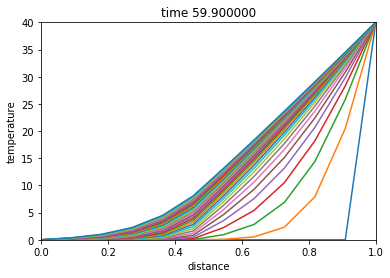

In [7]:
# Diffusion in 1D, with forward Euler by hand
#   du / dt = c(x) * d^2u / dx^2,
#   with boundary values at endpoints of unit interval,
#   initial value 0 at all points in unit interval, 
#   and with boundary values at endpoints
#   and with varying thermal conductivity c(x)

# Parameters of discretization and the equation

xspan  = (0, 1)         # Left and right endpoints of the 1-D interval
k      = 10             # Number of discrete points on the line, not including fixed-temp endpoints
dx     = (xspan[1] - xspan[0]) / (k+1)   # Difference between adjacent discrete points on line

tspan  = (0, 60)        # Starting and stopping times
dt     = .1             # Length of time step for forward Euler ODE solution

uleft  = 0              # Fixed temperature at left endpoint of interval
uright = 40             # Fixed temperature at right endpoint of interval
u0    = np.zeros(k)     # Initial value of interior points at time 0 

c = np.ones(k) * .005   # Thermal conductivity at each interior point

# Uncomment these lines to make the left half much less conductive than the right half
midpoint = int(k/2)
c[:midpoint] = .0005

# Get the matrix and the boundary-condition adjustment
A      = make_A_1D(k)
b      = np.zeros(k)
b[0]   = uleft
b[-1]  = uright

# For plotting, we include the endpoints in an array xplot of k+2 discrete points,
# and an array uplot of the k interior values along with the 2 boundary values.
xplot         = np.linspace(xspan[0], xspan[1], k+2)
uplot         = np.empty(k+2)
uplot[0]      = uleft   
uplot[1:k+1]  = u0
uplot[-1]     = uright  

# First plot
%matplotlib inline
plt.figure()
plt.plot(xplot, uplot)
plt.axis([xspan[0], xspan[1], uleft, uright])
plt.xlabel('distance')
plt.ylabel('temperature')
plt.title('time %f' % (tspan[0]))
ax = plt.gca()
nsteps = 1
plot_freq = 20


u = u0

# Now take steps in time from start to finish...
for t in np.arange(tspan[0], tspan[1], dt):
    udot = -c * (A @ u - b) / dx**2
    u    = u + udot * dt
    nsteps += 1
    
    if nsteps % plot_freq == 0:
        uplot[1:k+1] = u
        #plt.figure()
        plt.plot(xplot, uplot)
        plt.axis([xspan[0], xspan[1], uleft, uright])
        plt.xlabel('distance')
        plt.ylabel('temperature')
        plt.title('time %f' % (t+dt))
        
